In [1]:
import findspark
import pyspark
findspark.init()

In [2]:
import pyspark
from pyspark.sql import SparkSession

spark=SparkSession.builder.getOrCreate()

df=spark.sql("select 'spark ' as hello ")

df.show()

+------+
| hello|
+------+
|spark |
+------+



In [3]:
from pymongo import MongoClient
from pyspark.sql import functions as F
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer, NGram, ChiSqSelector,HashingTF, IndexToString
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

client = MongoClient('localhost', 27017)
db = client['reddit_data']

def fetch_data(collection, label):
    data = []
    for entry in db[collection].find({}, {"_id": 0, "prompt": 1, "completion": 1}):
        if 'prompt' in entry and 'completion' in entry:
            text = entry['prompt'] + " " + entry['completion']
            data.append((text, label))
    return data

data_yta = fetch_data('YTA', 'YTA')
data_nta = fetch_data('NTA', 'NTA')

data_combined = data_yta + data_nta

In [10]:

def create_wordcloud(data):
    text = " ".join(data)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

def visualize_data_distribution(df, title):
    data_pd = df.toPandas()
    fig = px.histogram(data_pd, x="label", title=title)
    fig.show()

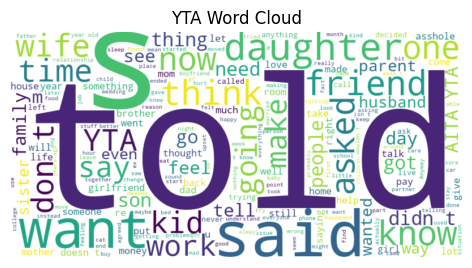

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


yta_text = " ".join([text for text, label in data_yta])
nta_text = " ".join([text for text, label in data_nta])


wordcloud_yta = WordCloud(width=800, height=400, background_color='white').generate(yta_text)
wordcloud_nta = WordCloud(width=800, height=400, background_color='white').generate(nta_text)

plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)
plt.imshow(wordcloud_yta, interpolation='bilinear')
plt.title('YTA Word Cloud')
plt.axis('off')

plt.show()

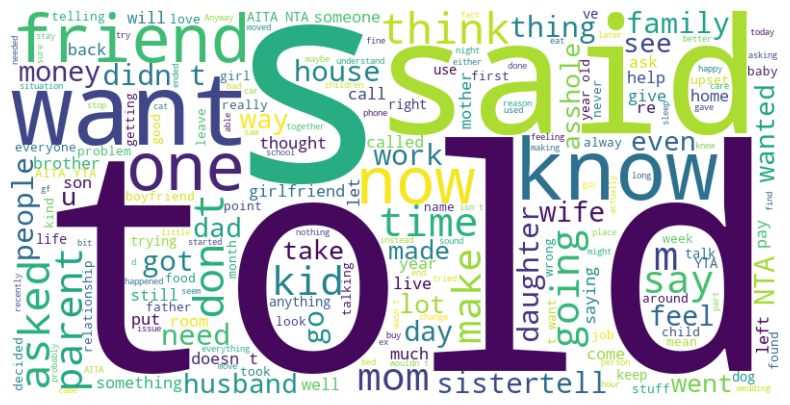

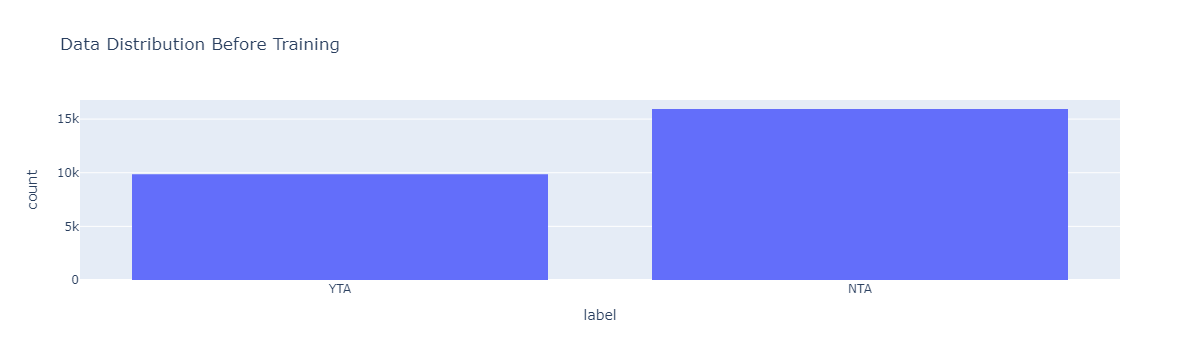

In [12]:

texts = [row[0] for row in data_combined]
create_wordcloud(texts)

visualize_data_distribution(df, "Data Distribution Before Training")

In [6]:
spark = SparkSession.builder \
    .appName("SentimentAnalysis") \
    .master("local[*]") \
    .config("spark.driver.memory", "16G") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryoserializer.buffer.max", "2000M") \
    .config("spark.driver.maxResultSize", "0") \
    .getOrCreate()

schema = StructType([
    StructField("text", StringType(), True),
    StructField("label", StringType(), True)
])
df = spark.createDataFrame(data_combined, schema)


class_distribution = df.groupBy("label").count().toPandas()
print(class_distribution)


count_ntas = class_distribution[class_distribution["label"] == "NTA"]["count"].values[0]
df_ytas = df.filter(df.label == "YTA")
df_ntas = df.filter(df.label == "NTA")
df_ytas_oversampled = df_ytas.sample(withReplacement=True, fraction=count_ntas / df_ytas.count())
df_balanced = df_ytas_oversampled.union(df_ntas)


train_data, validation_data, test_data = df_balanced.randomSplit([0.7, 0.15, 0.15], seed=42)


additional_stopwords = ["and", "i", "to", "the", "a", "her", "she", "my", "that", "of", "was", "for", "is", "it", "in", "you", "me", "with", "but", "have"]
tokenizer = Tokenizer(inputCol="text", outputCol="words")
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered", stopWords=StopWordsRemover.loadDefaultStopWords("english") + additional_stopwords)
ngram = NGram(n=2, inputCol="filtered", outputCol="bigrams")
count_vectorizer = CountVectorizer(inputCol="bigrams", outputCol="rawFeatures", vocabSize=10000)
idf = IDF(inputCol="rawFeatures", outputCol="features")
label_indexer = StringIndexer(inputCol="label", outputCol="indexedLabel")

rf = RandomForestClassifier(featuresCol="features", labelCol="indexedLabel", numTrees=100)

pipeline = Pipeline(stages=[
    tokenizer,
    stopwords_remover,
    ngram,
    count_vectorizer,
    idf,
    label_indexer,
    rf
])


param_grid = (ParamGridBuilder()
              .addGrid(rf.numTrees, [50, 100, 150])
              .addGrid(rf.maxDepth, [5, 10, 15])
              .build())

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=param_grid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1"),
                          numFolds=3)


cv_model = crossval.fit(train_data)


predictions = cv_model.transform(validation_data)
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedRecall")

f1_score = evaluator_f1.evaluate(predictions)
recall_score = evaluator_recall.evaluate(predictions)
print(f"Validation F1 Score: {f1_score}")
print(f"Validation Recall: {recall_score}")


test_predictions = cv_model.transform(test_data)
test_f1_score = evaluator_f1.evaluate(test_predictions)
test_recall_score = evaluator_recall.evaluate(test_predictions)
print(f"Test F1 Score: {test_f1_score}")
print(f"Test Recall: {test_recall_score}")

  label  count
0   YTA   9848
1   NTA  15942
Validation F1 Score: 0.9978974016916554
Validation Recall: 0.9978973927670312
Test F1 Score: 0.9985241443822747
Test Recall: 0.9985241408391313


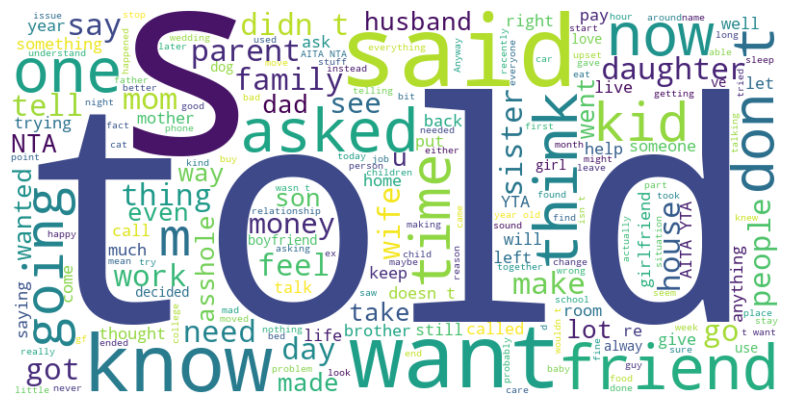

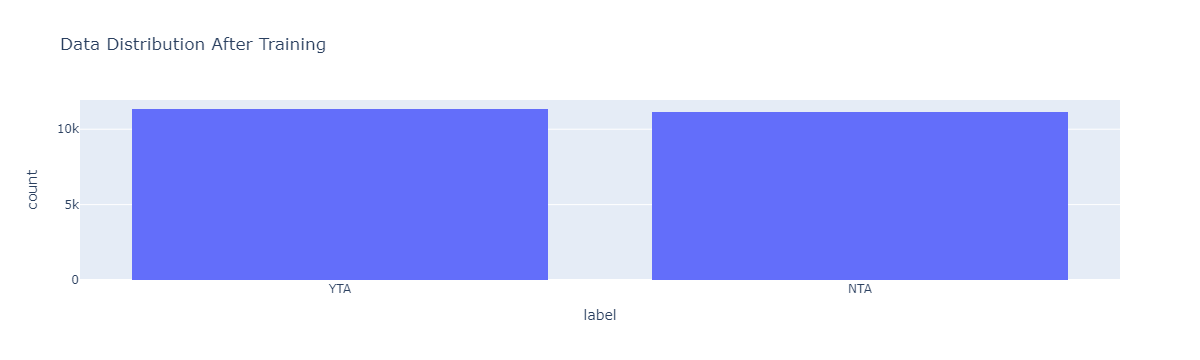

In [13]:

texts_after = [row['text'] for row in train_data.collect()]
create_wordcloud(texts_after)

visualize_data_distribution(train_data, "Data Distribution After Training")

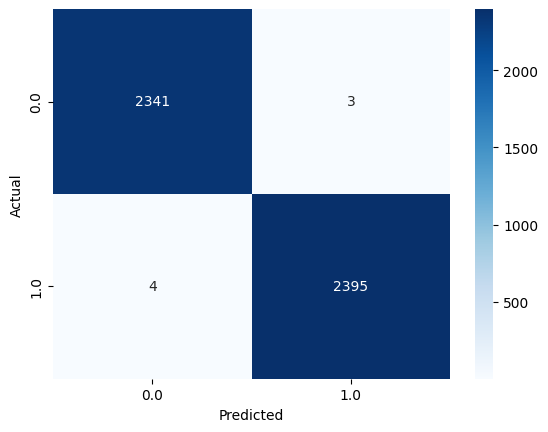

In [7]:
def plot_confusion_matrix(predictions, label_col, prediction_col):
    y_true = predictions.select(label_col).toPandas()
    y_pred = predictions.select(prediction_col).toPandas()
    cm = pd.crosstab(y_true[label_col], y_pred[prediction_col], rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.show()

plot_confusion_matrix(test_predictions, "indexedLabel", "prediction")


In [8]:
def predict_sentiment(text):
    single_df = spark.createDataFrame([(text,)], ["text"])
    prediction = cv_model.transform(single_df)
    indexer_model = label_indexer.fit(df)
    label_map = {i: label for i, label in enumerate(indexer_model.labels)}
    predicted_label = prediction.select("prediction").collect()[0]["prediction"]
    return label_map[predicted_label]


sample_text = "I have four boys - 16yo, 11yo twins and a 7yo. I can't explain it, but there has always been a buffer between me and my 16yo. The best way to describe it is like two magnets pushing each other away. I chalked it up to his wanting to be independent and expected that my other three would be the same. They are not that way. For example, I am very affectionate and playful with my other three kids and they enjoy and seek it. My 16yo was never a huggy kid and preferred to play with kids over me most of the time.  I have a connection with the other three that I never had with my 16yo. He is like me in the sense that he has a strong work ethic and is an avid learner. He sets high standards for himself. I absolutely trust him. The biggest irony is that the one male who he is closest with his uncle from his mom's side.\n\nI was having a rare meaningful conversation where I told him all of this. It just came out. I think he was both hurt and complimented at the same time. \n\nI am divorced with their mom, but we co-parent equally. He is closer with her than me."
predicted_sentiment = predict_sentiment(sample_text)
print(f"Predicted sentiment: {predicted_sentiment}")

Predicted sentiment: YTA
